In [ ]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import xgboost as xgb
import catboost as cb

from catboost import Pool

# --- 3. Фиксация SEED для воспроизводимости ---
RANDOM_STATE = 42

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_seed(RANDOM_STATE)

# ВАЖНО: Укажите правильный путь к папке с данными
DATA_PATH = 'data/'

Mounted at /content/drive


In [3]:
print("Загрузка данных...")

train = pd.read_csv(f'{DATA_PATH}/train.csv', parse_dates=['timestamp'])
targets = pd.read_csv(f'{DATA_PATH}/targets.csv')
candidates = pd.read_csv(f'{DATA_PATH}/candidates.csv')


books = pd.read_csv(f'{DATA_PATH}/books.csv')
users = pd.read_csv(f'{DATA_PATH}/users.csv')
genres = pd.read_csv(f'{DATA_PATH}/genres.csv')
book_genres = pd.read_csv(f'{DATA_PATH}/book_genres.csv')
book_descriptions = pd.read_csv(f'{DATA_PATH}/book_descriptions.csv')
print("Данные успешно загружены.")

Загрузка данных...
Данные успешно загружены.


In [4]:
print("Предварительная обработка данных...")


book_genres_agg = book_genres.groupby('book_id')['genre_id'].apply(list).reset_index()
books_meta = pd.merge(books, book_genres_agg, on='book_id', how='left')

books_meta = pd.merge(books_meta, book_descriptions, on='book_id', how='left')
books_meta['description'] = books_meta['description'].fillna("")

books_meta['publication_year'].replace(-1, books_meta['publication_year'].mode()[0], inplace=True)
for col in ['language', 'publisher', 'author_id']:
    books_meta[col].fillna(books_meta[col].mode()[0], inplace=True)

users['age'].replace(-1, users['age'].median(), inplace=True)
users['gender'].fillna(users['gender'].mode()[0], inplace=True)

print("Метаданные объединены и обработаны.")
del book_descriptions, book_genres_agg, genres, book_genres
gc.collect()

Предварительная обработка данных...
Метаданные объединены и обработаны.


/tmp/ipython-input-2061561100.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_meta['publication_year'].replace(-1, books_meta['publication_year'].mode()[0], inplace=True)
/tmp/ipython-input-2061561100.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

0

In [5]:
print("Начало этапа инжиниринга признаков...")

book_features = train.groupby('book_id').agg(
    book_reads_count=('has_read', lambda x: (x == 1).sum()),
    book_plans_count=('has_read', lambda x: (x == 0).sum()),
    book_avg_rating=('rating', 'mean'),
    book_interactions_count=('user_id', 'count')
).reset_index()
book_features['book_read_plan_ratio'] = book_features['book_reads_count'] / (book_features['book_plans_count'] + 1e-6)

user_features = train.groupby('user_id').agg(
    user_reads_count=('has_read', lambda x: (x == 1).sum()),
    user_plans_count=('has_read', lambda x: (x == 0).sum()),
    user_avg_rating=('rating', 'mean'),
    user_interactions_count=('book_id', 'count'),
    user_unique_books=('book_id', 'nunique'),
    user_activity_days=('timestamp', lambda x: (x.max() - x.min()).days if x.nunique() > 1 else 0)
).reset_index()
user_features['user_read_plan_ratio'] = user_features['user_reads_count'] / (user_features['user_plans_count'] + 1e-6)

tfidf = TfidfVectorizer(max_features=5000)
book_desc_embeddings = tfidf.fit_transform(books_meta['description'])

user_profiles = {}
train_read = train[train['has_read'] == 1]
user_book_matrix = train_read.groupby('user_id')['book_id'].apply(list)
book_id_to_idx = {book_id: i for i, book_id in enumerate(books_meta['book_id'])}

for user_id, book_ids in tqdm(user_book_matrix.items(), desc="Создание профилей пользователей"):
    book_indices = [book_id_to_idx[b_id] for b_id in book_ids if b_id in book_id_to_idx]
    if len(book_indices) > 0:
        mean_vector = book_desc_embeddings[book_indices].mean(axis=0)
        user_profiles[user_id] = np.asarray(mean_vector)

print("Основные признаки и профили созданы.")

Начало этапа инжиниринга признаков...


Создание профилей пользователей: 0it [00:00, ?it/s]

Основные признаки и профили созданы.


In [6]:
def create_features_for_df(df, is_train=False):
    """Функция для обогащения датасета всеми созданными признаками."""
    df = pd.merge(df, books_meta, on='book_id', how='left')
    df = pd.merge(df, users, on='user_id', how='left')
    df = pd.merge(df, book_features, on='book_id', how='left')
    df = pd.merge(df, user_features, on='user_id', how='left')

    cosine_sims = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Расчет cosine similarity"):
        user_id, book_id = row['user_id'], row['book_id']
        sim = 0.0
        if user_id in user_profiles and book_id in book_id_to_idx:
            book_vec = book_desc_embeddings[book_id_to_idx[book_id]]
            user_vec = user_profiles[user_id]
            sim = cosine_similarity(user_vec, book_vec)[0][0]
        cosine_sims.append(sim)
    df['cosine_sim_desc'] = cosine_sims

    df['rating_diff'] = df['avg_rating'] - df['user_avg_rating']

    if not is_train:
        train_pairs = train.set_index(['user_id', 'book_id']).index
        df_pairs = df.set_index(['user_id', 'book_id']).index
        df['is_cold_candidate'] = (~df_pairs.isin(train_pairs)).astype(int)

    df.fillna(-1, inplace=True)
    return df

print("Формирование обучающей выборки...")
train['relevance'] = train['has_read'].apply(lambda x: 2 if x == 1 else 1)
train_df = create_features_for_df(train, is_train=True)
train_groups = train_df.groupby('user_id').size().to_numpy()

print("\nФормирование тестовой выборки...")
test_df_exploded = candidates.assign(book_id=candidates.book_id_list.str.split(',')).explode('book_id')
test_df_exploded['book_id'] = pd.to_numeric(test_df_exploded['book_id'])
test_df = create_features_for_df(test_df_exploded.drop('book_id_list', axis=1))
test_groups = test_df.groupby('user_id').size().to_numpy()

features_to_drop = [
    'user_id', 'book_id', 'has_read', 'rating', 'timestamp', 'relevance',
    'title', 'author_name', 'genre_id', 'description', 'book_id_list'
]
feature_names = [col for col in train_df.columns if col not in features_to_drop and train_df[col].dtype != 'object']

X_train = train_df[feature_names]
y_train = train_df['relevance']
X_test = test_df[feature_names]

assert all(X_train.columns == X_test.columns)
print(f"\nВыборки сформированы. Количество признаков: {len(feature_names)}")


Формирование обучающей выборки...


Расчет cosine similarity:   0%|          | 0/269078 [00:00<?, ?it/s]


Формирование тестовой выборки...


Расчет cosine similarity:   0%|          | 0/81049 [00:00<?, ?it/s]


Выборки сформированы. Количество признаков: 21


39

In [ ]:
print("Начало обучения моделей...")

# --- Обучение XGBoost Ranker ---
print("Обучение XGBoost Ranker...")
xgb_ranker = xgb.XGBRanker(
    objective='rank:ndcg',
    eval_metric=['ndcg@20'],
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    tree_method='hist',
    early_stopping_rounds=50,
)
xgb_ranker.fit(X_train, y_train, group=train_groups, eval_set=[(X_train, y_train)], eval_group=[train_groups], verbose=100)


# --- Обучение CatBoost Ranker ---
print("\nОбучение CatBoost Ranker...")

print("Сортировка данных для CatBoost...")
train_df_sorted = train_df.sort_values('user_id').reset_index(drop=True)

X_train_sorted = train_df_sorted[feature_names]
y_train_sorted = train_df_sorted['relevance']
group_id_sorted = train_df_sorted['user_id']

categorical_features_indices = [
    i for i, col_name in enumerate(X_train_sorted.columns)
    if 'id' in col_name or col_name in ['gender', 'language', 'publisher', 'is_cold_candidate']
]
print(f"Определено {len(categorical_features_indices)} категориальных признаков.")
print([X_train_sorted.columns[i] for i in categorical_features_indices])



train_pool = Pool(
    data=X_train_sorted,
    label=y_train_sorted,
    group_id=group_id_sorted,
    cat_features=categorical_features_indices
)

cat_ranker = cb.CatBoostRanker(
    loss_function='YetiRank',
    eval_metric='NDCG:top=20',
    iterations=1500,
    learning_rate=0.07,
    depth=7,
    random_seed=RANDOM_STATE,
    task_type='CPU',
    verbose=100,
    early_stopping_rounds=50
)

cat_ranker.fit(
    train_pool,
    eval_set=train_pool
)

print("Обучение моделей завершено.")

Начало обучения моделей...
Обучение XGBoost Ranker...
[0]	validation_0-ndcg@20:0.96768
[100]	validation_0-ndcg@20:0.99771
[200]	validation_0-ndcg@20:0.99801
[300]	validation_0-ndcg@20:0.99827
[400]	validation_0-ndcg@20:0.99841
[500]	validation_0-ndcg@20:0.99859
[600]	validation_0-ndcg@20:0.99868
[700]	validation_0-ndcg@20:0.99876
[800]	validation_0-ndcg@20:0.99882
[900]	validation_0-ndcg@20:0.99887
[999]	validation_0-ndcg@20:0.99894

Обучение CatBoost Ranker...
Сортировка данных для CatBoost...
Определено 4 категориальных признаков.
['author_id', 'language', 'publisher', 'gender']
Groupwise loss function. OneHotMaxSize set to 10


Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=20;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9937599	best: 0.9937599 (0)	total: 125ms	remaining: 3m 6s
100:	test: 0.9989597	best: 0.9989597 (100)	total: 6.95s	remaining: 1m 36s
200:	test: 0.9993289	best: 0.9993289 (200)	total: 15.4s	remaining: 1m 39s
300:	test: 0.9995217	best: 0.9995284 (296)	total: 22.4s	remaining: 1m 29s
400:	test: 0.9996125	best: 0.9996125 (400)	total: 30.6s	remaining: 1m 23s
500:	test: 0.9996808	best: 0.9996808 (500)	total: 39.1s	remaining: 1m 18s
600:	test: 0.9997155	best: 0.9997156 (599)	total: 45.9s	remaining: 1m 8s
700:	test: 0.9997404	best: 0.9997404 (700)	total: 54.4s	remaining: 1m 1s
800:	test: 0.9997531	best: 0.9997532 (797)	total: 1m 1s	remaining: 53.3s
900:	test: 0.9997644	best: 0.9997644 (900)	total: 1m 9s	remaining: 46.2s
1000:	test: 0.9997769	best: 0.9997769 (996)	total: 1m 17s	remaining: 38.7s
1100:	test: 0.9997812	best: 0.9997812 (1098)	total: 1m 24s	remaining: 30.7s
1200:	test: 0.9997939	best: 0.9997939 (1200)	total: 1m 33s	remaining: 23.2s
1300:	test: 0.9998018	best: 0.9998018 (128

Анализ важности признаков...


/tmp/ipython-input-743936628.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


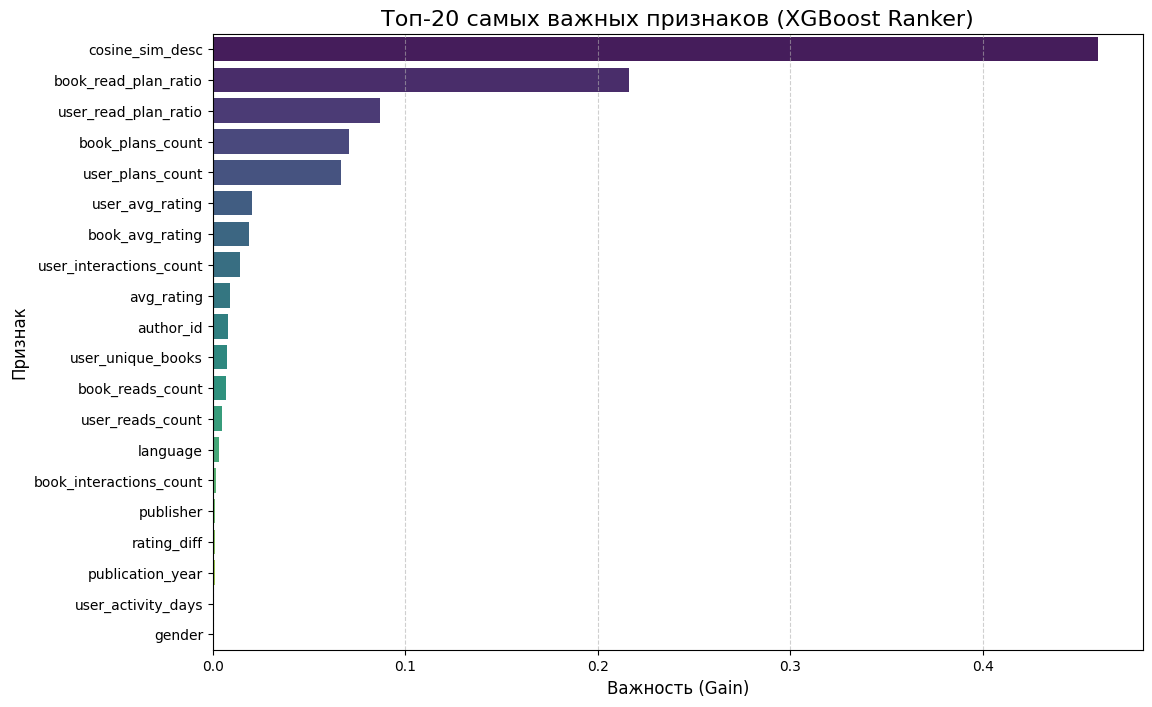

/tmp/ipython-input-743936628.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


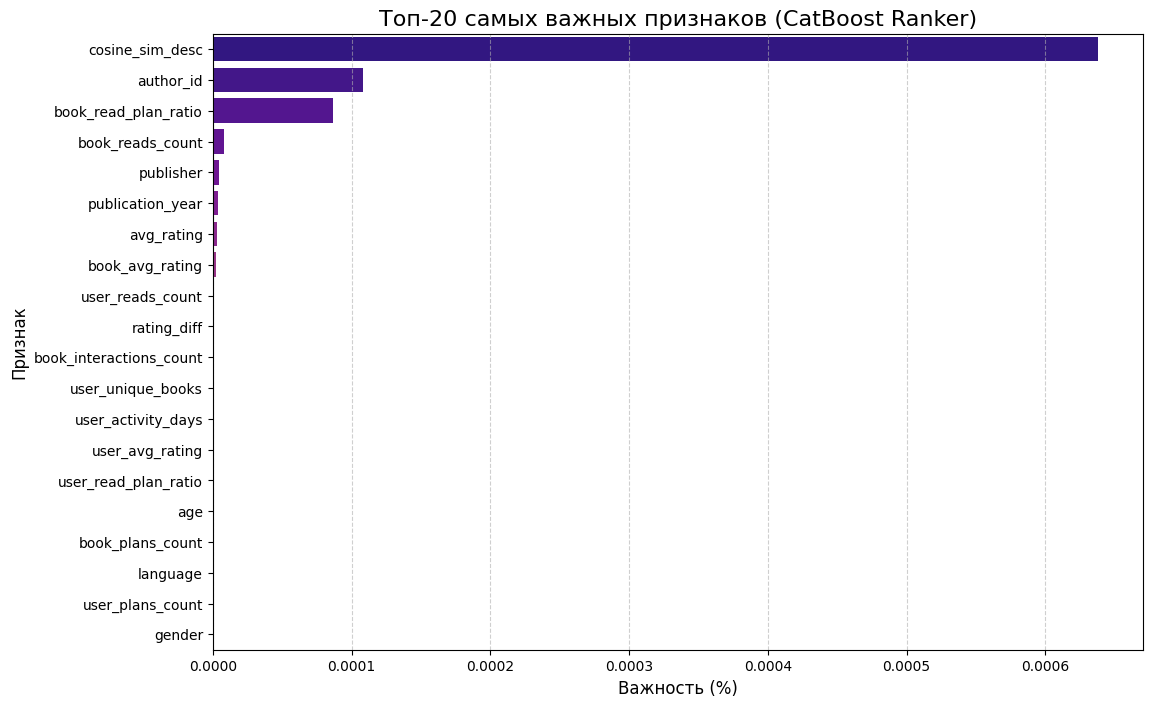

In [9]:
print("Анализ важности признаков...")

# --- 1. Важность признаков для XGBoost Ranker ---

xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_ranker.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=xgb_feature_importance.head(20),
    palette='viridis'
)
plt.title('Топ-20 самых важных признаков (XGBoost Ranker)', fontsize=16)
plt.xlabel('Важность (Gain)', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


# --- 2. Важность признаков для CatBoost Ranker ---

cat_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': cat_ranker.get_feature_importance(data=train_pool)
}).sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=cat_feature_importance.head(20),
    palette='plasma'
)
plt.title('Топ-20 самых важных признаков (CatBoost Ranker)', fontsize=16)
plt.xlabel('Важность (%)', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [11]:
print("Формирование предсказаний")

test_df['xgb_score'] = xgb_ranker.predict(X_test)
test_df['cat_score'] = cat_ranker.predict(X_test)

test_df['ensemble_score'] = 0.0
scaler = MinMaxScaler()

xgb_weight = 0.35
cat_weight = 0.65

xgb_power = 1.1
cat_power = 1.1

scores = []
for user_id in test_df['user_id'].unique():
    user_df = test_df[test_df['user_id'] == user_id]

    scaled_xgb = scaler.fit_transform(user_df[['xgb_score']]).flatten()
    scaled_cat = scaler.fit_transform(user_df[['cat_score']]).flatten()

    ensemble_score = (
        xgb_weight * (scaled_xgb ** xgb_power) +
        cat_weight * (scaled_cat ** cat_power)
    )
    scores.extend(ensemble_score)

test_df['ensemble_score'] = scores


submission = test_df.sort_values(['user_id', 'ensemble_score'], ascending=[True, False])

submission = submission.groupby('user_id')['book_id'].apply(list).reset_index(name='book_id_list')

submission['book_id_list'] = submission['book_id_list'].apply(lambda x: ','.join(map(str, x[:20])))

submission = pd.merge(targets, submission, on='user_id', how='left')
submission['book_id_list'].fillna('', inplace=True)

submission_path = '/content/submission.csv'
submission.to_csv(submission_path, index=False)

print(f"Файл с решением сохранен по пути: {submission_path}")
print("\nПример итогового файла:")
print(submission.head())

Формирование предсказаний и продвинутого ансамбля...
Файл с решением сохранен по пути: /content/submission.csv

Пример итогового файла:
   user_id                                       book_id_list
0      210  2600001,11936,254097,2370751,971259,2180196,22...
1     1380  2548861,2290484,145975,2379664,1098150,998313,...
2     2050  2575827,1918727,460492,867246,2300795,1021078,...
3     2740  987516,112023,2327258,1553798,5535190,549194,2...
4     4621  1809950,1964216,2595660,2446687,2347564,134176...


/tmp/ipython-input-68868717.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submission['book_id_list'].fillna('', inplace=True)
